# Metaheuristic Optimization With Input Multiplication Factors:

This code includes the function `multiply_factor_on_dbs`, which is used to apply a multiplication factor to the input data from the database. This is intended for simulating a building in House 3 (identified as 2 in the code, since Python indexing starts at 0).

To change the factor or the house ID, simply modify the values of the `multiplier_factor` and `house_id` variables.

In [1]:
#  Imports
from src.parsers import HMParser
from src.resources import BinaryResource, Generator, Load, Storage, Vehicle
from src.scenes import HMProblemScene
import build_data
from build_data import ext_pyomo_vals
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd

from help_methods import *
# Ignore the warnings (only demonstration purposes!)
import warnings
warnings.filterwarnings("ignore")

## Set Up Varibles - My SQL Database:
#### Performance Notes for Specific Dates
- November 6th runs quickly.
- At the end of November 13th, the forecasts are higher than the actual consumption.
- November 16th/17th is an example of very poor forecasting.

In [2]:
_specific_date = '2019-11-06'  # Change the date
_time_step = 60                 # Change the time interval (in minutes)

## Set Up Variables - Metaheuristic Model:

If you change here, it changes automatically in the entire simulation.

In [3]:
pop_size=20
n_iter=10000
iter_tolerance=1000
algorithm = 'mgo' #Options are 'hyde_df', 'mgo' and 'do'

## Input Excel Path: 

If you modify the input path here, it will automatically update throughout the entire simulation. ;D

In [4]:
_file_path_excel = 'data/EC_V4_new_UC1.xlsx'

## Defining the multiplier factor and the house id:

If you change here, it will change automatically in the entire code! ;D

In [5]:
multiplier_factor = 5
house_id = 2 #Observe that there are 5 houses, which IDs comes from 0 to 4

# Method 1 - Forecast Data:

In this method, it is used the data from mysql forecast databases as input for load and generators.

In [6]:
# Data parsing
method_obj_1 = build_data.Data(_file_path=_file_path_excel, ec_id=1) 

In [7]:
method1_folder = f"./input_data/{algorithm}/UC2/method_1"

# Define generators
gens1 = Generator(name='gens',
                 value=np.zeros(method_obj_1.data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(method_obj_1.data.generator['p_forecast'].shape),
                 upper_bound=method_obj_1.data.generator['p_forecast'],
                 cost=method_obj_1.data.generator['cost_parameter_b'],
                 cost_nde=method_obj_1.data.generator['cost_nde'],
                 is_renewable=method_obj_1.data.generator['type_generator'])

method_obj_1.get_data_from_db(specific_date=_specific_date, table="generators_forecast", end = 24*60//_time_step, experiment_id = 17, time_step=_time_step, folder=method1_folder)

# Multipling house 3 - id 2 (OBS: the ids come from 0 to 4 inside python)
method_obj_1.multiply_factor_on_dbs(input_data=method_obj_1.data.generator, variable = 'p_forecast', factor=multiplier_factor, house_id=house_id)
method_obj_1.save_data_from_db("generators_forecast", method_obj_1.data.generator, 0, 24*60//_time_step, method1_folder)


# Define loads
loads1 = Load(name='loads',
             value=method_obj_1.data.load['p_forecast'],
             lower_bound=np.zeros(method_obj_1.data.load['p_forecast'].shape),
             upper_bound=method_obj_1.data.load['p_forecast'],
             cost=np.ones(method_obj_1.data.load['p_forecast'].shape),
             cost_cut=method_obj_1.data.load['cost_cut'],
             cost_reduce=method_obj_1.data.load['cost_reduce'],
             cost_ens=method_obj_1.data.load['cost_ens'])


method_obj_1.get_data_from_db(specific_date=_specific_date, table="loads_forecast", end = 24*60//_time_step, experiment_id = 23, time_step=_time_step, folder=method1_folder)

# Multipling house 3 - id 2 (OBS: the ids come from 0 to 4 inside python)
method_obj_1.multiply_factor_on_dbs(input_data=method_obj_1.data.load, variable = 'p_forecast', factor=multiplier_factor, house_id=house_id)
method_obj_1.save_data_from_db("loads_forecast", method_obj_1.data.load, 0, 24*60//_time_step, method1_folder)

# Define storage
stor1 = Storage(name='stor',
               value=np.zeros(method_obj_1.data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(method_obj_1.data.storage['p_charge_limit'].shape),
               upper_bound=(method_obj_1.data.storage['energy_capacity'] *
                            np.ones(method_obj_1.data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(method_obj_1.data.storage['p_charge_limit'].shape),
               cost_discharge=method_obj_1.data.storage['discharge_price'],
               cost_charge=method_obj_1.data.storage['charge_price'],
               capacity_max=method_obj_1.data.storage['energy_capacity'],
               capacity_min=method_obj_1.data.storage['energy_min_percentage'],
               initial_charge=method_obj_1.data.storage['initial_state'],
               discharge_efficiency=method_obj_1.data.storage['discharge_efficiency'],
               discharge_max=method_obj_1.data.storage['p_discharge_limit'],
               charge_efficiency=method_obj_1.data.storage['charge_efficiency'],
               charge_max=method_obj_1.data.storage['p_charge_limit'],
               #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
               #@TODO Coloquei array tamanho 4 no capital cost pois há 4 css
               capital_cost=np.array([0.05250, 0.10500, 0.01575, 0.01575]))
stor1.to_json(path=method1_folder)

# Define vehicle to grid
v2g1 = Vehicle(name='evs',
              value=np.zeros(method_obj_1.data.vehicle['schedule_charge'].shape),
              lower_bound=(method_obj_1.data.vehicle['e_capacity_max'] * method_obj_1.data.vehicle['min_technical_soc'] *
                           np.ones(method_obj_1.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(method_obj_1.data.vehicle['e_capacity_max'] * np.ones(method_obj_1.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(method_obj_1.data.vehicle['schedule_charge'].shape),
              cost_discharge=method_obj_1.data.vehicle['discharge_price'][:, 0],
              cost_charge=method_obj_1.data.vehicle['charge_price'][:, 0],
              capacity_max=method_obj_1.data.vehicle['e_capacity_max'],
              initial_charge=np.ones(method_obj_1.data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=method_obj_1.data.vehicle['min_technical_soc'],
              discharge_efficiency=method_obj_1.data.vehicle['discharge_efficiency'],
              charge_efficiency=method_obj_1.data.vehicle['charge_efficiency'],
              #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
              #@TODO Coloquei array tamanho 7 no capital cost pois há 7 carros
              capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063, 0.063, 0.063]), 
              schedule_discharge=method_obj_1.data.vehicle['schedule_discharge'],
              schedule_charge=method_obj_1.data.vehicle['schedule_charge'])
v2g1.to_json(path=method1_folder)

# Define imports and exports
pimp1 = BinaryResource(name='pImp',
                      value=np.zeros(method_obj_1.data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_1.data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_1.data.peers['import_contracted_p_max'][0, :],
                      cost=method_obj_1.data.peers['buy_price'][0, :],
                      is_active=np.zeros(method_obj_1.data.peers['import_contracted_p_max'][0, :].shape))
pimp1.to_json(path=method1_folder)

pexp1 = BinaryResource(name='pExp',
                      value=np.zeros(method_obj_1.data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_1.data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_1.data.peers['export_contracted_p_max'][0, :],
                      cost=method_obj_1.data.peers['sell_price'][0, :],
                      is_active=np.zeros(method_obj_1.data.peers['export_contracted_p_max'][0, :].shape))
pexp1.to_json(path=method1_folder)

# Establish the components
ec_components = {'gen': gens1,
                 'loads': loads1,
                 'stor': stor1,
                 'evs': v2g1,
                 'pimp': pimp1,
                 'pexp': pexp1}

ec_components

{'gen': gens,
 'loads': loads,
 'stor': stor,
 'evs': evs,
 'pimp': pImp,
 'pexp': pExp}

In [8]:
# Create the scene

scene = HMProblemScene(name='EC1', data=ec_components, hm_parser=method_obj_1.data, pop_size=pop_size,
                       n_iter=n_iter, iter_tolerance=iter_tolerance)
scene.initialize()
scene.run(algorithm=algorithm)


The chosen Metaheuristic is hyde_df.



  0%|          | 2/10000 [00:00<24:53,  6.69it/s]

100%|██████████| 10000/10000 [15:32<00:00, 10.72it/s] 


In [9]:
scene.to_json(path=f"./results/{algorithm}/UC2/method_1", filename="scene1_results")

In [10]:
scene.export_profile_to_excel(scene.current_best['genActPower'], scene.current_best['storDchActPower'],
                              scene.current_best['v2gDchActPower'], scene.current_best['loadRedActPower'],
                              scene.current_best['loadCutActPower'], scene.current_best['loadENS'],
                              scene.current_best['pImp'], scene.current_best['genExcActPower'],
                              scene.current_best['storChActPower'], scene.current_best['v2gChActPower'],
                              loads1.value,
                              name=f"iterations_{n_iter}_profile_data_1.xlsx", path=f"results/{algorithm}/UC2/method_1"
                              )

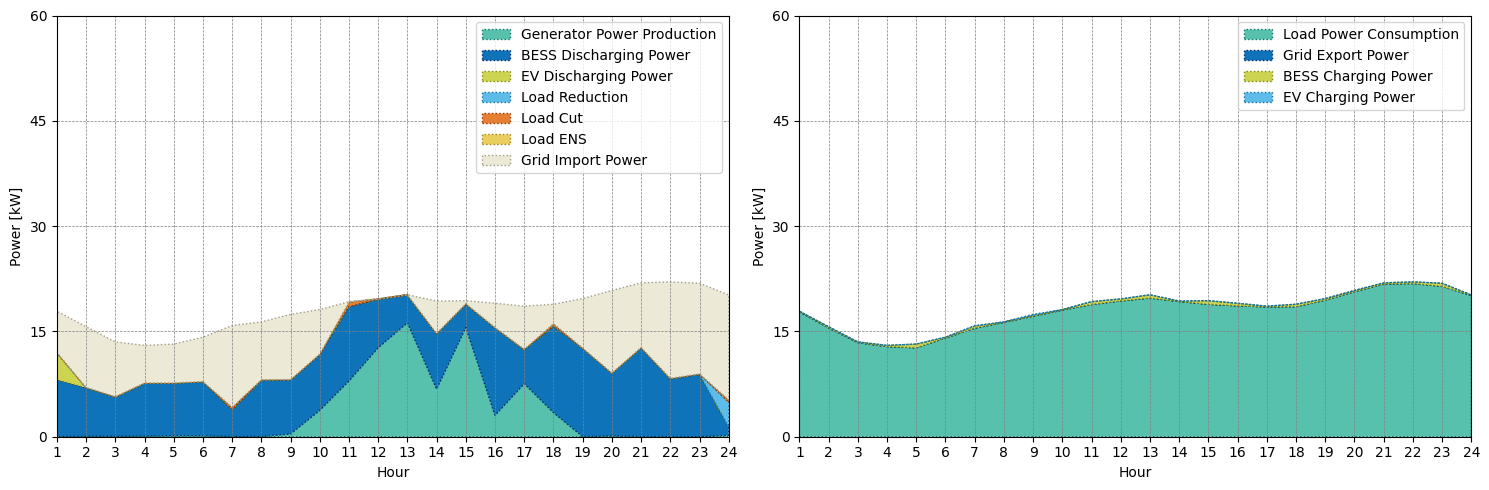

In [11]:
scene.plot(scene.current_best['genActPower'], scene.current_best['storDchActPower'],
                              scene.current_best['v2gDchActPower'], scene.current_best['loadRedActPower'],
                              scene.current_best['loadCutActPower'], scene.current_best['loadENS'],
                              scene.current_best['pImp'], scene.current_best['genExcActPower'],
                              scene.current_best['storChActPower'], scene.current_best['v2gChActPower'],
                              loads1.value, save=True,
                              name=f"iterations_{n_iter}_profile_data_1", path=f"plots/{algorithm}/UC2/method_1", graph_max=60, graph_step=15)

In [12]:
#scene.components['evs'].capital_cost
v2g1.cost_discharge

array([0.05, 0.06, 0.05, 0.05, 0.06, 0.06, 0.06], dtype=object)

In [13]:
# Sum matrices along the columns

scene.algo.population_fitness

[33.23032031178316,
 33.24387232544142,
 33.30601102451624,
 33.12931851464836,
 33.28501440584972,
 33.203999903293926,
 33.185222709900664,
 33.081129286042234,
 33.27198819329703,
 33.08669827871607,
 33.221460423433896,
 33.43764726461518,
 33.252815521165076,
 33.277471749041,
 33.19688175278891,
 33.16756881523061,
 33.09567675921784,
 33.22604489132681,
 33.09540251778109,
 33.28818590736263]

In [14]:
 # Check the population

scene.algo.population

array([[4.04180569e-05, 1.05296101e-02, 7.74337456e-06, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [2.39576007e-05, 1.15748565e-02, 4.33026965e-06, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [4.23453412e-05, 1.08272171e-02, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       ...,
       [7.22272459e-05, 9.78530166e-03, 5.31232441e-06, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [8.97726065e-05, 1.07452568e-02, 6.22376247e-06, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [3.21177503e-05, 1.00596505e-02, 1.32159244e-05, ...,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

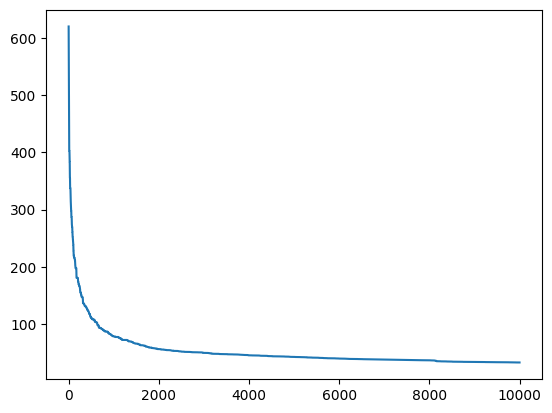

In [15]:
plt.plot(scene.algo.population_history_fitness)

In [16]:
scene.algo.population_history_fitness

[619.9223109023307,
 599.4671457751234,
 599.4671457751234,
 537.2564415144332,
 494.2076247409975,
 494.2076247409975,
 494.2076247409975,
 482.21078583752495,
 430.5222548342113,
 424.2890918110351,
 424.2890918110351,
 412.6485678535361,
 412.6485678535361,
 402.88243536131824,
 402.88243536131824,
 402.88243536131824,
 402.88243536131824,
 402.88243536131824,
 402.88243536131824,
 396.80670458924646,
 389.1046751717535,
 389.1046751717535,
 383.6305831172827,
 383.6305831172827,
 383.6305831172827,
 368.1369830610108,
 361.2012133366578,
 361.2012133366578,
 355.3346315118474,
 355.3346315118474,
 355.3346315118474,
 342.98975111378985,
 342.98975111378985,
 337.52568270738186,
 337.52568270738186,
 337.52568270738186,
 337.52568270738186,
 337.52568270738186,
 337.52568270738186,
 337.52568270738186,
 337.52568270738186,
 332.7404035166257,
 327.41523378317737,
 327.41523378317737,
 322.44344665382545,
 322.44344665382545,
 319.87529905455875,
 314.45820353293374,
 311.78202470087

In [17]:
scene.algo.population_fitness

[33.23032031178316,
 33.24387232544142,
 33.30601102451624,
 33.12931851464836,
 33.28501440584972,
 33.203999903293926,
 33.185222709900664,
 33.081129286042234,
 33.27198819329703,
 33.08669827871607,
 33.221460423433896,
 33.43764726461518,
 33.252815521165076,
 33.277471749041,
 33.19688175278891,
 33.16756881523061,
 33.09567675921784,
 33.22604489132681,
 33.09540251778109,
 33.28818590736263]

In [18]:
scene.current_best_fitness

33.08669827871607

# Method 2 - Real Data

In [19]:
# Data parsing
method_obj_2 = build_data.Data(_file_path=_file_path_excel, ec_id=1) 

In [20]:
method_obj_2.data.storage.keys()

dict_keys(['p_charge_limit', 'p_discharge_limit', 'charge_price', 'discharge_price', 'internal_bus_location', 'battery_type', 'owner', 'manager', 'type_contract', 'energy_capacity', 'energy_min_percentage', 'charge_efficiency', 'discharge_efficiency', 'initial_state', 'p_charge_max', 'p_discharge_max'])

In [21]:
method2_folder = f"./input_data/{algorithm}/UC2/method_2"

# Define generators
gens2 = Generator(name='gens2',
                 value=np.zeros(method_obj_2.data.generator['p_forecast'].shape),
                 lower_bound=np.zeros(method_obj_2.data.generator['p_forecast'].shape),
                 upper_bound=method_obj_2.data.generator['p_forecast'],
                 cost=method_obj_2.data.generator['cost_parameter_b'],
                 cost_nde=method_obj_2.data.generator['cost_nde'],
                 is_renewable=method_obj_2.data.generator['type_generator'])

method_obj_2.get_data_from_db(specific_date=_specific_date, table="generators", end = 24*60//_time_step, 
                             time_step=_time_step, folder=method2_folder)

# Multipling house 3 - id 2 (OBS: the ids come from 0 to 4 inside python)
method_obj_2.multiply_factor_on_dbs(input_data=method_obj_2.data.generator, variable = 'p_forecast', factor=multiplier_factor, house_id=house_id)
method_obj_2.save_data_from_db("generators", method_obj_2.data.generator, 0, 24*60//_time_step, method2_folder)

# Define loads
loads2 = Load(name='loads2',
             value=method_obj_2.data.load['p_forecast'],
             lower_bound=np.zeros(method_obj_2.data.load['p_forecast'].shape),
             upper_bound=method_obj_2.data.load['p_forecast'],
             cost=np.ones(method_obj_2.data.load['p_forecast'].shape),
             cost_cut=method_obj_2.data.load['cost_cut'],
             cost_reduce=method_obj_2.data.load['cost_reduce'],
             cost_ens=method_obj_2.data.load['cost_ens'])


method_obj_2.get_data_from_db(specific_date=_specific_date, table="loads", end = 24*60//_time_step, 
                            time_step=_time_step, folder=method2_folder, save=True)

# Multipling house 3 - id 2 (OBS: the ids come from 0 to 4 inside python)
method_obj_2.multiply_factor_on_dbs(input_data=method_obj_2.data.load, variable = 'p_forecast', factor=multiplier_factor, house_id=house_id)
method_obj_2.save_data_from_db("loads", method_obj_2.data.load, 0, 24*60//_time_step, method2_folder)

# Define storage
stor2 = Storage(name='stor2',
               value=np.zeros(method_obj_2.data.storage['p_charge_limit'].shape),
               lower_bound=np.zeros(method_obj_2.data.storage['p_charge_limit'].shape),
               upper_bound=(method_obj_2.data.storage['energy_capacity'] *
                            np.ones(method_obj_2.data.storage['p_charge_limit'].shape).transpose()).transpose(),
               cost=np.ones(method_obj_2.data.storage['p_charge_limit'].shape),
               cost_discharge=method_obj_2.data.storage['discharge_price'],
               cost_charge=method_obj_2.data.storage['charge_price'],
               capacity_max=method_obj_2.data.storage['energy_capacity'],
               capacity_min=method_obj_2.data.storage['energy_min_percentage'],
               initial_charge=method_obj_2.data.storage['initial_state'],
               discharge_efficiency=method_obj_2.data.storage['discharge_efficiency'],
               discharge_max=method_obj_2.data.storage['p_discharge_limit'],
               charge_efficiency=method_obj_2.data.storage['charge_efficiency'],
               charge_max=method_obj_2.data.storage['p_charge_limit'],
               #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
               #@TODO Coloquei array tamanho 4 no capital cost pois há 4 css
               capital_cost=np.array([0.05250, 0.10500, 0.01575, 0.01575]))
stor2.to_json(path=method2_folder)

# Define vehicle to grid
v2g2 = Vehicle(name='evs2',
              value=np.zeros(method_obj_2.data.vehicle['schedule_charge'].shape),
              lower_bound=(method_obj_2.data.vehicle['e_capacity_max'] * method_obj_2.data.vehicle['min_technical_soc'] *
                           np.ones(method_obj_2.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              upper_bound=(method_obj_2.data.vehicle['e_capacity_max'] * np.ones(method_obj_2.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
              cost=np.ones(method_obj_2.data.vehicle['schedule_charge'].shape),
              cost_discharge=method_obj_2.data.vehicle['discharge_price'][:, 0],
              cost_charge=method_obj_2.data.vehicle['charge_price'][:, 0],
              capacity_max=method_obj_2.data.vehicle['e_capacity_max'],
              initial_charge=np.ones(method_obj_2.data.vehicle['schedule_charge'].shape) * 0.8,
              min_charge=method_obj_2.data.vehicle['min_technical_soc'],
              discharge_efficiency=method_obj_2.data.vehicle['discharge_efficiency'],
              charge_efficiency=method_obj_2.data.vehicle['charge_efficiency'],
              #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
              #@TODO Coloquei array tamanho 7 no capital cost pois há 7 carros
              capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063, 0.063, 0.063]), 
              schedule_discharge=method_obj_2.data.vehicle['schedule_discharge'],
              schedule_charge=method_obj_2.data.vehicle['schedule_charge'])
v2g2.to_json(path=method2_folder)

# Define imports and exports
pimp2 = BinaryResource(name='pImp2',
                      value=np.zeros(method_obj_2.data.peers['import_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_2.data.peers['import_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_2.data.peers['import_contracted_p_max'][0, :],
                      cost=method_obj_2.data.peers['buy_price'][0, :],
                      is_active=np.zeros(method_obj_2.data.peers['import_contracted_p_max'][0, :].shape))
pimp2.to_json(path=method2_folder)

pexp2 = BinaryResource(name='pExp2',
                      value=np.zeros(method_obj_2.data.peers['export_contracted_p_max'][0, :].shape),
                      lower_bound=np.zeros(method_obj_2.data.peers['export_contracted_p_max'][0, :].shape),
                      upper_bound=method_obj_2.data.peers['export_contracted_p_max'][0, :],
                      cost=method_obj_2.data.peers['sell_price'][0, :],
                      is_active=np.zeros(method_obj_2.data.peers['export_contracted_p_max'][0, :].shape))
pexp2.to_json(path=method2_folder)

# Establish the components
ec_components = {'gen': gens2,
                 'loads': loads2,
                 'stor': stor2,
                 'evs': v2g2,
                 'pimp': pimp2,
                 'pexp': pexp2}

ec_components

{'gen': gens2,
 'loads': loads2,
 'stor': stor2,
 'evs': evs2,
 'pimp': pImp2,
 'pexp': pExp2}

In [22]:
# Create the scene

scene2 = HMProblemScene(name='EC2', data=ec_components, hm_parser=method_obj_2.data, pop_size=pop_size,
                       n_iter=n_iter, iter_tolerance=iter_tolerance)
scene2.initialize()
scene2.run(algorithm=algorithm)


The chosen Metaheuristic is hyde_df.



 27%|██▋       | 2729/10000 [03:45<10:00, 12.10it/s]


KeyboardInterrupt: 

In [ ]:
scene2.to_json(path=f"./results/{algorithm}/UC2/method_2", filename="scene2_results")

In [ ]:
scene2.current_best.keys()

dict_keys(['genActPower', 'genExcActPower', 'pImp', 'pExp', 'loadRedActPower', 'loadCutActPower', 'loadENS', 'storDchActPower', 'storChActPower', 'EminRelaxStor', 'storEnerState', 'v2gDchActPower', 'v2gChActPower', 'EminRelaxEV', 'v2gEnerState', 'genXo', 'loadXo', 'storDchXo', 'storChXo', 'v2gDchXo', 'v2gChXo'])

In [ ]:
scene2.export_profile_to_excel(scene2.current_best['genActPower'], scene2.current_best['storDchActPower'],
                              scene2.current_best['v2gDchActPower'], scene2.current_best['loadRedActPower'],
                              scene2.current_best['loadCutActPower'], scene2.current_best['loadENS'],
                              scene2.current_best['pImp'], scene2.current_best['genExcActPower'],
                              scene2.current_best['storChActPower'], scene2.current_best['v2gChActPower'],
                              loads2.value,
                              name=f"iterations_{n_iter}_profile_data_2.xlsx", path=f"results/{algorithm}/UC2/method_2"
                              )

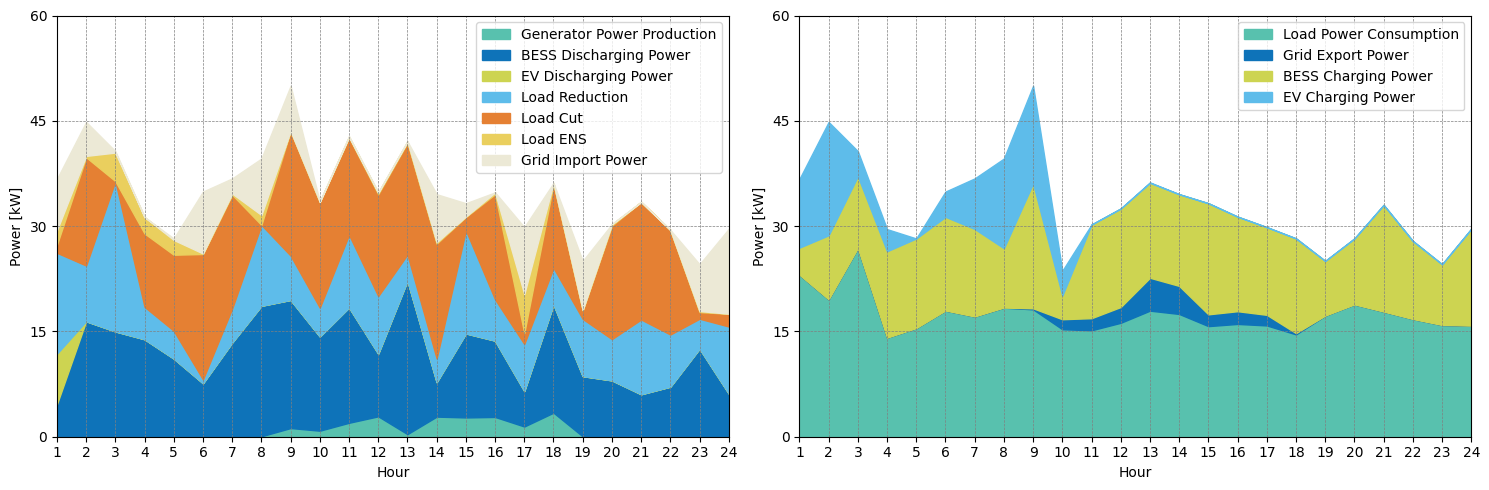

In [ ]:
scene2.plot(scene2.current_best['genActPower'], scene2.current_best['storDchActPower'],
                              scene2.current_best['v2gDchActPower'], scene2.current_best['loadRedActPower'],
                              scene2.current_best['loadCutActPower'], scene2.current_best['loadENS'],
                              scene2.current_best['pImp'], scene2.current_best['genExcActPower'],
                              scene2.current_best['storChActPower'], scene2.current_best['v2gChActPower'],
                              loads2.value, save=True,
                              name=f"iterations_{n_iter}_profile_data_2", path=f"plots/{algorithm}/UC2/method_2", graph_max=60, graph_step=15)

In [ ]:
#scene.components['evs'].capital_cost
v2g2.cost_discharge

array([0.05, 0.06, 0.05, 0.05, 0.06, 0.06, 0.06], dtype=object)

In [ ]:
# Sum matrices along the columns

scene2.algo.population_fitness

[100596.5215635206,
 100522.38948448002,
 500631.47493399936,
 200695.73780931355,
 300494.8837084957,
 300500.17381864396,
 487.3990651770472,
 100515.01488196733,
 300568.10917305714,
 400565.57518257794,
 300589.8858335037,
 200571.8508067503,
 200607.22190060958,
 100597.84599575945,
 100523.79876803045,
 300550.8653858741,
 400489.19946543267,
 578.376805482368,
 400601.7306620144,
 200524.8030103925]

In [ ]:
 # Check the population

scene2.algo.population

array([[6.28323617e-09, 7.93676257e-09, 1.64136444e-09, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.35242989e-09, 2.48374726e-10, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [3.69623591e-09, 9.00767979e-09, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       ...,
       [5.13283135e-09, 1.78228657e-09, 0.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [9.56586701e-09, 1.00539633e-08, 7.43093080e-09, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [2.15439653e-09, 1.48650403e-09, 4.22688869e-09, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

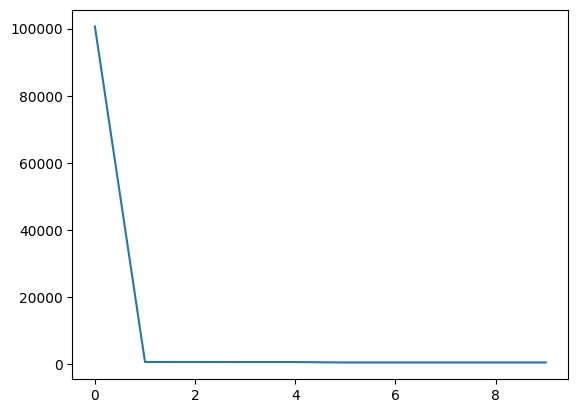

In [ ]:
plt.plot(scene2.algo.population_history_fitness)

In [ ]:
scene2.algo.population_history_fitness

[100645.88231859836,
 641.9297220606428,
 627.2278947262604,
 611.403922681913,
 611.403922681913,
 487.3990651770472,
 487.3990651770472,
 487.3990651770472,
 487.3990651770472,
 487.3990651770472]

In [ ]:
scene2.algo.population_fitness

[100596.5215635206,
 100522.38948448002,
 500631.47493399936,
 200695.73780931355,
 300494.8837084957,
 300500.17381864396,
 487.3990651770472,
 100515.01488196733,
 300568.10917305714,
 400565.57518257794,
 300589.8858335037,
 200571.8508067503,
 200607.22190060958,
 100597.84599575945,
 100523.79876803045,
 300550.8653858741,
 400489.19946543267,
 578.376805482368,
 400601.7306620144,
 200524.8030103925]

In [ ]:
scene2.current_best_fitness

513.3047430122645

# Method 3 - Forecast + Real Data

In [ ]:
# Data parsing
method_obj_3 = build_data.Data(_file_path=_file_path_excel, ec_id=1) 

In [ ]:
method_obj_3.data.storage.keys()

dict_keys(['p_charge_limit', 'p_discharge_limit', 'charge_price', 'discharge_price', 'internal_bus_location', 'battery_type', 'owner', 'manager', 'type_contract', 'energy_capacity', 'energy_min_percentage', 'charge_efficiency', 'discharge_efficiency', 'initial_state', 'p_charge_max', 'p_discharge_max'])

## OBS: Preciso validar isso aqui, se o método 3 está igual ao original

In [ ]:
all_data = []
all_models = []
results_dict = {}


integral_of_error_gen = np.zeros((5, 1))
integral_of_error_load = np.zeros((5, 1))

# True - Forecast - Based on Deterministic PYECOM Model (pyecomWforecats.ipynb):
forecast_error_load_at_time = method_obj_2.data.load['p_forecast'][:, :] - method_obj_1.get_data().load['p_forecast'][:, :] 
forecast_error_gen_at_time = method_obj_2.data.generator['p_forecast'][:, :] - method_obj_1.get_data().generator['p_forecast'][:, :]

for i in range(1, 24*60//_time_step+1):
    
    print(i)
    #  Result extraction - Saving the results on CSVs:
    results_folder = f'./results/{algorithm}/UC2/method_3/{i}_step'
    method3_folder = f"./input_data/{algorithm}/UC2/method_3/{i}_step"

    # Define generators
    gens3 = Generator(name='gens3',
                    value=np.zeros(method_obj_3.data.generator['p_forecast'].shape),
                    lower_bound=np.zeros(method_obj_3.data.generator['p_forecast'].shape),
                    upper_bound=method_obj_3.data.generator['p_forecast'],
                    cost=method_obj_3.data.generator['cost_parameter_b'],
                    cost_nde=method_obj_3.data.generator['cost_nde'],
                    is_renewable=method_obj_3.data.generator['type_generator'])

    method_obj_3.get_data_from_db(specific_date=_specific_date, table="generators_forecast", 
                                  experiment_id = 17, start=i, end = 24*60//_time_step, 
                                  time_step=_time_step)

    method_obj_3.get_data_from_db(specific_date=_specific_date, table="generators", start=0, end = i, 
                                  time_step=_time_step)
    
    # Multiplying House 3 - Id 2 Inputs by 5:
    method_obj_3.multiply_factor_on_dbs(input_data=method_obj_3.data.generator, variable = 'p_forecast', factor=multiplier_factor, house_id=house_id)
    method_obj_3.save_data_from_db("generators", method_obj_3.data.generator, start=0, end = i, folder= method3_folder)

    
    
    # Define loads
    loads3 = Load(name='loads3',
                value=method_obj_3.data.load['p_forecast'],
                lower_bound=np.zeros(method_obj_3.data.load['p_forecast'].shape),
                upper_bound=method_obj_3.data.load['p_forecast'],
                cost=np.ones(method_obj_3.data.load['p_forecast'].shape),
                cost_cut=method_obj_3.data.load['cost_cut'],
                cost_reduce=method_obj_3.data.load['cost_reduce'],
                cost_ens=method_obj_3.data.load['cost_ens'])


    method_obj_3.get_data_from_db(specific_date=_specific_date, table="loads_forecast", experiment_id = 23, 
                                  start=i, end = 24*60//_time_step, time_step=_time_step)

    method_obj_3.get_data_from_db(specific_date=_specific_date, table="loads",start=0, end = i, 
                                  time_step=_time_step)


    # Multiplying House 3 - Id 2 Inputs by 5:
    method_obj_3.multiply_factor_on_dbs(input_data=method_obj_3.data.load, variable = 'p_forecast', factor=multiplier_factor, house_id=house_id)
    method_obj_3.save_data_from_db("loads", method_obj_3.data.load, start=0, end = i, folder= method3_folder)

    # Define storage
    stor3 = Storage(name='stor3',
                value=np.zeros(method_obj_3.data.storage['p_charge_limit'].shape),
                lower_bound=np.zeros(method_obj_3.data.storage['p_charge_limit'].shape),
                upper_bound=(method_obj_3.data.storage['energy_capacity'] *
                                np.ones(method_obj_3.data.storage['p_charge_limit'].shape).transpose()).transpose(),
                cost=np.ones(method_obj_3.data.storage['p_charge_limit'].shape),
                cost_discharge=method_obj_3.data.storage['discharge_price'],
                cost_charge=method_obj_3.data.storage['charge_price'],
                capacity_max=method_obj_3.data.storage['energy_capacity'],
                capacity_min=method_obj_3.data.storage['energy_min_percentage'],
                initial_charge=method_obj_3.data.storage['initial_state'],
                discharge_efficiency=method_obj_3.data.storage['discharge_efficiency'],
                discharge_max=method_obj_3.data.storage['p_discharge_limit'],
                charge_efficiency=method_obj_3.data.storage['charge_efficiency'],
                charge_max=method_obj_3.data.storage['p_charge_limit'],
                #capital_cost=np.tile(np.array([0.05250, 0.10500, 0.01575]), 10))
                #@TODO Coloquei array tamanho 4 no capital cost pois há 4 css
                capital_cost=np.array([0.05250, 0.10500, 0.01575, 0.01575]))
    stor3.to_json(filename=f"stor_0-{i}",path=method3_folder)

    # Define vehicle to grid
    v2g3 = Vehicle(name='evs3',
                value=np.zeros(method_obj_3.data.vehicle['schedule_charge'].shape),
                lower_bound=(method_obj_3.data.vehicle['e_capacity_max'] * method_obj_3.data.vehicle['min_technical_soc'] *
                            np.ones(method_obj_3.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
                upper_bound=(method_obj_3.data.vehicle['e_capacity_max'] * np.ones(method_obj_3.data.vehicle['schedule_charge'].shape).transpose()).transpose(),
                cost=np.ones(method_obj_3.data.vehicle['schedule_charge'].shape),
                cost_discharge=method_obj_3.data.vehicle['discharge_price'][:, 0],
                cost_charge=method_obj_3.data.vehicle['charge_price'][:, 0],
                capacity_max=method_obj_3.data.vehicle['e_capacity_max'],
                initial_charge=np.ones(method_obj_3.data.vehicle['schedule_charge'].shape) * 0.8,
                min_charge=method_obj_3.data.vehicle['min_technical_soc'],
                discharge_efficiency=method_obj_3.data.vehicle['discharge_efficiency'],
                charge_efficiency=method_obj_3.data.vehicle['charge_efficiency'],
                #capital_cost=np.tile(np.array([0.042, 0.063, 0.042, 0.042, 0.063]), 10),
                #@TODO Coloquei array tamanho 7 no capital cost pois há 7 carros
                capital_cost=np.array([0.042, 0.063, 0.042, 0.042, 0.063, 0.063, 0.063]), 
                schedule_discharge=method_obj_3.data.vehicle['schedule_discharge'],
                schedule_charge=method_obj_3.data.vehicle['schedule_charge'])
    v2g3.to_json(filename=f"v2g_0-{i}",path=method3_folder)

    # Define imports and exports
    pimp3 = BinaryResource(name='pImp3',
                        value=np.zeros(method_obj_3.data.peers['import_contracted_p_max'][0, :].shape),
                        lower_bound=np.zeros(method_obj_3.data.peers['import_contracted_p_max'][0, :].shape),
                        upper_bound=method_obj_3.data.peers['import_contracted_p_max'][0, :],
                        cost=method_obj_3.data.peers['buy_price'][0, :],
                        is_active=np.zeros(method_obj_3.data.peers['import_contracted_p_max'][0, :].shape))
    pimp3.to_json(filename=f"pimp_0-{i}",path=method3_folder)

    pexp3 = BinaryResource(name='pExp3',
                        value=np.zeros(method_obj_3.data.peers['export_contracted_p_max'][0, :].shape),
                        lower_bound=np.zeros(method_obj_3.data.peers['export_contracted_p_max'][0, :].shape),
                        upper_bound=method_obj_3.data.peers['export_contracted_p_max'][0, :],
                        cost=method_obj_3.data.peers['sell_price'][0, :],
                        is_active=np.zeros(method_obj_3.data.peers['export_contracted_p_max'][0, :].shape))
    pexp3.to_json(filename=f"pexp_0-{i}",path=method3_folder)

    # Establish the components
    ec_components = {'gen': gens3,
                    'loads': loads3,
                    'stor': stor3,
                    'evs': v2g3,
                    'pimp': pimp3,
                    'pexp': pexp3}

    ec_components
    
    # Create the scene
    scene3 = HMProblemScene(name='EC3', data=ec_components, hm_parser=method_obj_3.data, pop_size=pop_size,
                       n_iter=n_iter, iter_tolerance=iter_tolerance)
    scene3.initialize()
    scene3.run(algorithm=algorithm)

    # Store results in a dictionary

    results_dict = store_results(i, results_dict, 
                    scene3.current_best['pImp'], scene3.current_best['pExp'], scene3.current_best['genActPower'], 
                    scene3.current_best['genExcActPower'], scene3.current_best['genXo'], scene3.current_best['loadRedActPower'], 
                    scene3.current_best['loadCutActPower'], scene3.current_best['loadENS'], scene3.current_best['loadXo'], 
                    scene3.current_best['storEnerState'], scene3.current_best['storDchActPower'], scene3.current_best['storChActPower'], 
                    scene3.current_best['storDchXo'], scene3.current_best['storChXo'], scene3.current_best['v2gChActPower'], 
                    scene3.current_best['v2gDchActPower'], scene3.current_best['v2gEnerState'],
                    scene3.current_best['v2gDchXo'], 
                    scene3.current_best['v2gChXo']
                    )
    scene3.export_profile_to_excel(scene2.current_best['genActPower'], scene2.current_best['storDchActPower'],
                              scene2.current_best['v2gDchActPower'], scene2.current_best['loadRedActPower'],
                              scene2.current_best['loadCutActPower'], scene2.current_best['loadENS'],
                              scene2.current_best['pImp'], scene2.current_best['genExcActPower'],
                              scene2.current_best['storChActPower'], scene2.current_best['v2gChActPower'],
                              loads2.value,
                              name=f"step_{i}_iterations_{n_iter}_profile_data_3.xlsx", path=results_folder
                              )
    

1

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 14.77it/s]


2

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 17.83it/s]


3

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 18.13it/s]


4

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 15.42it/s]


5

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 15.47it/s]


6

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 16.99it/s]


7

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 18.67it/s]


8

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 18.31it/s]


9

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 13.61it/s]


10

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 15.47it/s]


11

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 13.06it/s]


12

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:01<00:00,  9.04it/s]


13

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 11.39it/s]


14

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 11.40it/s]


15

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 13.23it/s]


16

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 15.87it/s]


17

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 15.61it/s]


18

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 17.03it/s]


19

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 13.58it/s]


20

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 17.66it/s]


21

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 17.74it/s]


22

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 19.08it/s]


23

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 17.15it/s]


24

The chosen Metaheuristic is hyde_df.



100%|██████████| 10/10 [00:00<00:00, 16.68it/s]


In [ ]:
#Plot the operation of the community results

result_genActPower = np.array([results_dict[hour]['genActPowerInit'] for hour in sorted(results_dict.keys())])
result_storDchActPower = np.array([results_dict[hour]['storDischargeInit'] for hour in sorted(results_dict.keys())])
result_v2gDchActPower = np.array([results_dict[hour]['v2gDischargeInit'] for hour in sorted(results_dict.keys())])
result_loadRedActPower = np.array([results_dict[hour]['loadRedActPowerInit'] for hour in sorted(results_dict.keys())])
result_loadCutActPower = np.array([results_dict[hour]['loadCutActPowerInit'] for hour in sorted(results_dict.keys())])
result_loadENS = np.array([results_dict[hour]['loadENSInit'] for hour in sorted(results_dict.keys())])
result_pimp = np.array([results_dict[hour]['importsInit'] for hour in sorted(results_dict.keys())])
result_genExcActPower = np.array([results_dict[hour]['genExcPowerInit'] for hour in sorted(results_dict.keys())])
result_storChActPower = np.array([results_dict[hour]['storChargeInit'] for hour in sorted(results_dict.keys())])
result_v2gChActPower = np.array([results_dict[hour]['v2gChargeInit'] for hour in sorted(results_dict.keys())])



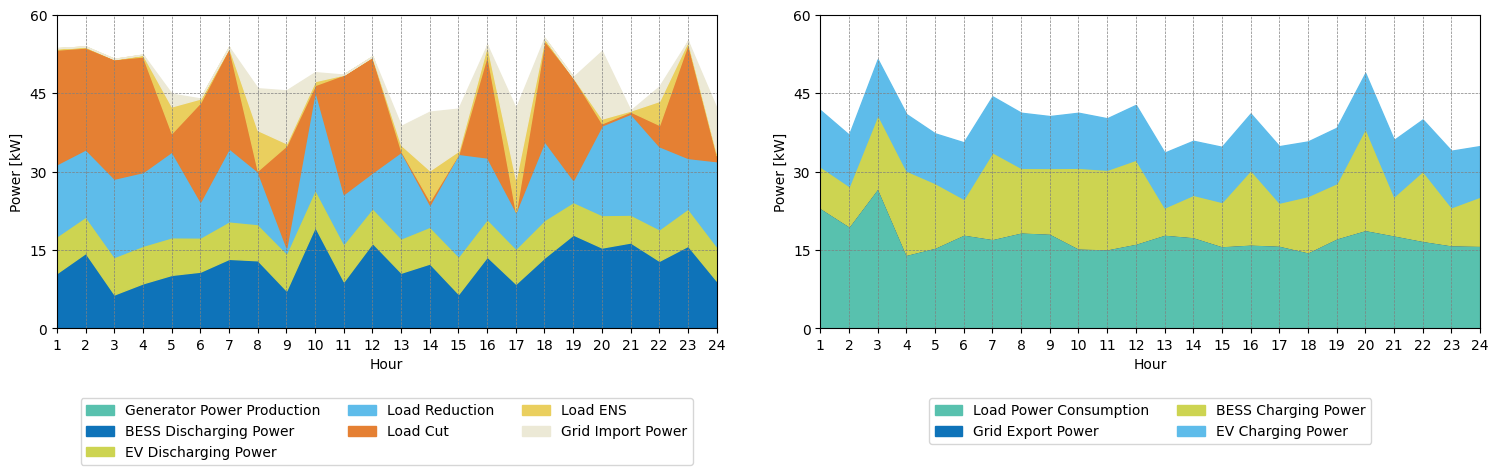

In [ ]:
plot_mixed_results(result_genActPower,
    result_storDchActPower,
    result_v2gDchActPower,
    result_loadRedActPower,
    result_loadCutActPower,
    result_loadENS,
    result_pimp,
    method_obj_2, #The method 2 enters here, although this is method 3. Based on original PyECOM.
    _time_step,
    result_genExcActPower,
    result_storChActPower,
    result_v2gChActPower,
    save = True,
    path = f'plots/{algorithm}/UC2/method_3',
    name =  f'iterations_{n_iter}_profile_data_3.png',
    graph_max = 60,
    graph_step = 15)

In [ ]:
# This function put on a excel all the data that was ploted on the previous part (plot_profile function)
export_mixed_results(
    result_genActPower,
    result_storDchActPower,
    result_v2gDchActPower,
    result_loadRedActPower,
    result_loadCutActPower,
    result_loadENS,
    result_pimp,
    method_obj_2, #The method 2 enters here, although this is method 3. Based on original PyECOM.
    _time_step,
    result_genExcActPower,
    result_storChActPower,
    result_v2gChActPower,
    path=f'./results/{algorithm}/UC2/method_3',  
    name=f'iterations_{n_iter}_profile_data_3.xlsx'   
)